In [1]:
import pandas as pd
import numpy as np
import os 
from tqdm import tqdm
import glob
from datetime import datetime 
import tushare as ts
ts.set_token('0948b6427e46bb1bc7fa60b52df96ab0080b9d4ff80209a5fee99277')
pro = ts.pro_api()

In [2]:
import numpy as np
import pandas as pd
from numpy import abs
from numpy import log
from numpy import sign
from scipy.stats import rankdata

def ts_sum(df, window=10):
    return df.rolling(window).sum()

def sma(df, window=10):
    return df.rolling(window).mean()

def stddev(df, window=10):
    return df.rolling(window).std()

def correlation(x, y, window=10):
    return x.rolling(window).corr(y)

def covariance(x, y, window=10):
    return x.rolling(window).cov(y)

def rolling_rank(na):
    return rankdata(na)[-1]

def ts_rank(df, window=10):
    return df.rolling(window).apply(rolling_rank)

def rolling_prod(na):
    return np.prod(na)

def product(df, window=10):
    return df.rolling(window).apply(rolling_prod)

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_max(df, window=10):
    return df.rolling(window).max()

def delta(df, period=1):
    return df.diff(period)

def delay(df, period=1):
    return df.shift(period)

def rank(df):
    return df.rank(axis=1, pct=True)
#     return df.rank(pct=True)

def scale(df, k=1):
    return df.mul(k).div(np.abs(df).sum())

def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax) + 1 

def ts_argmin(df, window=10):
    return df.rolling(window).apply(np.argmin) + 1

def decay_linear(df, period=10):
    if df.isnull().values.any():
        df.fillna(method='ffill', inplace=True)
        df.fillna(method='bfill', inplace=True)
        df.fillna(value=0, inplace=True)
    na_lwma = np.zeros_like(df)
    na_lwma[:period, :] = df.iloc[:period, :] 
    na_series = df.values
    divisor = period * (period + 1) / 2
    y = (np.arange(period) + 1) * 1.0 / divisor
    for row in range(period - 1, df.shape[0]):
        x = na_series[row - period + 1: row + 1, :]
        na_lwma[row, :] = (np.dot(x.T, y))
    return pd.DataFrame(na_lwma, index=df.index, columns=df.columns)  



In [3]:
price_PD_total = pd.read_csv('data/price_PD.csv', dtype = {'trade_date': 'str'})
price_PD_total = price_PD_total.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
price_PD_total = price_PD_total[price_PD_total.trade_date>='20210101']



In [4]:
all_stock = pro.stock_basic()

In [5]:
all_stock = all_stock[['ts_code','name','market']]
price_PD_total = pd.merge(price_PD_total,all_stock,how='left',on='ts_code')
price_PD_total = price_PD_total[['ts_code', 'name','market', 'trade_date', 'open', 'high', 'low',
       'close', 'pre_close','change', 'pct_chg', 'vol', 'amount']]


In [6]:
indus = pd.read_excel('data/a_stock_industry.xlsx')
indus = indus[['windcode','申万行业L1','申万行业L2','申万行业L3']]
indus.columns = ['ts_code','indus1','indus2','indus3']
indus.head()

,ts_code,indus1,indus2,indus3
0,000001.SZ,银行,银行Ⅱ,银行Ⅲ
1,000002.SZ,房地产,房地产开发Ⅱ,房地产开发Ⅲ
2,000004.SZ,计算机,计算机应用,IT服务
3,000005.SZ,公用事业,环保工程及服务Ⅱ,环保工程及服务Ⅲ
4,000006.SZ,房地产,房地产开发Ⅱ,房地产开发Ⅲ


In [7]:
price_PD_total = pd.merge(price_PD_total,indus,how='left',on='ts_code')

In [8]:
price_PD_total = price_PD_total[price_PD_total.market.isin(['主板','中小板','创业板'])]
price_PD_total = price_PD_total[~price_PD_total.name.str.contains('ST')].reset_index(drop=True)

In [9]:
price_PD_total['ret1'] = price_PD_total.groupby('ts_code').close.shift(-1)/price_PD_total.groupby('ts_code').close.shift(0) 


In [10]:
price_PD_total.head()

,ts_code,name,market,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,indus1,indus2,indus3,ret1
0,000001.SZ,平安银行,主板,20210104,18.9510,18.9510,18.2962,18.4549,19.1891,-0.7342,-3.8261,1554216.43,2891682.312,银行,银行Ⅱ,银行Ⅲ,0.976884
1,000001.SZ,平安银行,主板,20210105,18.2565,18.3359,17.6612,18.0283,18.4549,-0.4266,-2.3116,1821352.10,3284606.913,银行,银行Ⅱ,银行Ⅲ,1.076496
2,000001.SZ,平安银行,主板,20210106,17.9390,19.4074,17.8596,19.4074,18.0283,1.3791,7.6496,1934945.12,3648521.909,银行,银行Ⅱ,银行Ⅲ,1.017385
3,000001.SZ,平安银行,主板,20210107,19.3677,19.8242,19.0800,19.7448,19.4074,0.3374,1.7385,1584185.30,3111274.625,银行,银行Ⅱ,银行Ⅲ,0.997488
4,000001.SZ,平安银行,主板,20210108,19.7448,19.9432,19.1594,19.6952,19.7448,-0.0496,-0.2512,1195473.22,2348316.363,银行,银行Ⅱ,银行Ⅲ,1.026697


In [11]:
price_PD_wfq = pd.read_csv('data/price_PD_2015至今_未复权.csv')
price_PD_wfq.trade_date = price_PD_wfq.trade_date.astype('str')
price_PD_wfq = price_PD_wfq.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
price_PD_wfq['vwap'] = price_PD_wfq.amount/price_PD_wfq.vol
price_PD_wfq = price_PD_wfq[price_PD_wfq.ts_code.isin(price_PD_total.ts_code.unique())]



In [17]:
daily_info = {}
daily_info['open'] = price_PD_wfq.pivot('trade_date', 'ts_code', 'open')
daily_info['close'] = price_PD_wfq.pivot('trade_date', 'ts_code', 'close')
daily_info['high']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'high')
daily_info['low']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'low')
daily_info['volume']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'vol')
daily_info['amount']  = price_PD_wfq.pivot('trade_date', 'ts_code', 'amount')
daily_info['vwap']  = (daily_info['amount']*1000)/(daily_info['volume']*100+1) 
daily_info['returns']  = price_PD_total.pivot('trade_date', 'ts_code', 'pct_chg')



In [18]:
def fun(x):
    if x < 0.2: return 1
    elif 0.2 <= x < 0.4: return 2
    elif 0.4 <= x < 0.6: return 3
    elif 0.6 <= x < 0.8: return 4
    elif 0.8 <= x <= 1: return 5
    else: return np.nan
    
    

In [59]:
class AlphaLib(object):
    def __init__(self, daily_info):
        self.open = daily_info['open']
        self.high = daily_info['high']
        self.low = daily_info['low']
        self.close = daily_info['close']
        self.vwap = daily_info['vwap'] 
        self.volume = daily_info['volume'] 
        self.amount = daily_info['amount']
        self.returns = daily_info['returns']

    # Alpha#1	 (rank(Ts_ArgMax(SignedPower(((returns < 0) ? stddev(returns, 20) : close), 2.), 5)) -0.5)
    def alpha001(self):
        inner = self.close
        inner[self.returns < 0] = stddev(self.returns, 20)
        return rank(ts_argmax(inner ** 2, 5))
    
    # Alpha#2	 (-1 * correlation(rank(delta(log(volume), 2)), rank(((close - open) / open)), 6))
    def alpha002(self):
        df = -1 * correlation(rank(delta(log(self.volume), 2)), rank((self.close - self.open) / self.open), 6)
        return df.replace([-np.inf, np.inf], 0).fillna(value=0)
    
    # Alpha#3	 (-1 * correlation(rank(open), rank(volume), 10))
    def alpha003(self):
        df = -1 * correlation(rank(self.open), rank(self.volume), 10)
        return df.replace([-np.inf, np.inf], 0).fillna(value=0)
    
    # Alpha#4	 (-1 * Ts_Rank(rank(low), 9))
    def alpha004(self):
        return -1 * ts_rank(rank(self.low), 9)
    
    # Alpha#5	 (rank((open - (sum(vwap, 10) / 10))) * (-1 * abs(rank((close - vwap)))))
    def alpha005(self):
        return  (rank((self.open - (ts_sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
    
    # Alpha#6	 (-1 * correlation(open, volume, 10))
    def alpha006(self):
        df = -1 * correlation(self.open, self.volume, 10)
        return df.replace([-np.inf, np.inf], 0).fillna(value=0)
    
    # Alpha#7	 ((adv20 < volume) ? ((-1 * ts_rank(abs(delta(close, 7)), 60)) * sign(delta(close, 7))) : (-1* 1))
    def alpha007(self):
        adv20 = sma(self.volume, 20)
        alpha = -1 * ts_rank(abs(delta(self.close, 7)), 60) * sign(delta(self.close, 7))
        alpha[adv20 >= self.volume] = -1
        return alpha
    
    # Alpha#8	 (-1 * rank(((sum(open, 5) * sum(returns, 5)) - delay((sum(open, 5) * sum(returns, 5)),10))))
    def alpha008(self):
        return -1 * (rank(((ts_sum(self.open, 5) * ts_sum(self.returns, 5)) -
                           delay((ts_sum(self.open, 5) * ts_sum(self.returns, 5)), 10))))
    
    # Alpha#9	 ((0 < ts_min(delta(close, 1), 5)) ? delta(close, 1) : ((ts_max(delta(close, 1), 5) < 0) ?delta(close, 1) : (-1 * delta(close, 1))))
    def alpha009(self):
        delta_close = delta(self.close, 1)
        cond_1 = ts_min(delta_close, 5) > 0
        cond_2 = ts_max(delta_close, 5) < 0
        alpha = -1 * delta_close
        alpha[cond_1 | cond_2] = delta_close
        return alpha
    
    # Alpha#10	 rank(((0 < ts_min(delta(close, 1), 4)) ? delta(close, 1) : ((ts_max(delta(close, 1), 4) < 0)? delta(close, 1) : (-1 * delta(close, 1)))))
    def alpha010(self):
        delta_close = delta(self.close, 1)
        cond_1 = ts_min(delta_close, 4) > 0
        cond_2 = ts_max(delta_close, 4) < 0
        alpha = -1 * delta_close
        alpha[cond_1 | cond_2] = delta_close
        return alpha
    
    # Alpha#11	 ((rank(ts_max((vwap - close), 3)) + rank(ts_min((vwap - close), 3))) *rank(delta(volume, 3)))
    def alpha011(self):
        return ((rank(ts_max((self.vwap - self.close), 3)) + rank(ts_min((self.vwap - self.close), 3))) *rank(delta(self.volume, 3)))
    
    # Alpha#12	 (sign(delta(volume, 1)) * (-1 * delta(close, 1)))
    def alpha012(self):
        return sign(delta(self.volume, 1)) * (-1 * delta(self.close, 1))

    # Alpha#13	 (-1 * rank(covariance(rank(close), rank(volume), 5)))
    def alpha013(self):
        return -1 * rank(covariance(rank(self.close), rank(self.volume), 5))
    
    # Alpha#14	 ((-1 * rank(delta(returns, 3))) * correlation(open, volume, 10))
    def alpha014(self):
        df = correlation(self.open, self.volume, 10)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * rank(delta(self.returns, 3)) * df
    
    # Alpha#15	 (-1 * sum(rank(correlation(rank(high), rank(volume), 3)), 3))
    def alpha015(self):
        df = correlation(rank(self.high), rank(self.volume), 3)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * ts_sum(rank(df), 3)
    
    # Alpha#16	 (-1 * rank(covariance(rank(high), rank(volume), 5)))
    def alpha016(self):
        return -1 * rank(covariance(rank(self.high), rank(self.volume), 5))
    
    # Alpha#17	 (((-1 * rank(ts_rank(close, 10))) * rank(delta(delta(close, 1), 1))) *rank(ts_rank((volume / adv20), 5)))
    def alpha017(self):
        adv20 = sma(self.volume, 20)
        return -1 * (rank(ts_rank(self.close, 10)) *
                     rank(delta(delta(self.close, 1), 1)) *
                     rank(ts_rank((self.volume / adv20), 5)))
        
    # Alpha#18	 (-1 * rank(((stddev(abs((close - open)), 5) + (close - open)) + correlation(close, open,10))))
    def alpha018(self):
        df = correlation(self.close, self.open, 10)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * (rank((stddev(abs((self.close - self.open)), 5) + (self.close - self.open)) +
                          df))
    
    # Alpha#19	 ((-1 * sign(((close - delay(close, 7)) + delta(close, 7)))) * (1 + rank((1 + sum(returns,250)))))
    def alpha019(self):
        return ((-1 * sign((self.close - delay(self.close, 7)) + delta(self.close, 7))) *
                (1 + rank(1 + ts_sum(self.returns, 250))))
    
    # Alpha#20	 (((-1 * rank((open - delay(high, 1)))) * rank((open - delay(close, 1)))) * rank((open -delay(low, 1))))
    def alpha020(self):
        return -1 * (rank(self.open - delay(self.high, 1)) *
                     rank(self.open - delay(self.close, 1)) *
                     rank(self.open - delay(self.low, 1)))

    # Alpha#21	 ((((sum(close, 8) / 8) + stddev(close, 8)) < (sum(close, 2) / 2)) ? (-1 * 1) : (((sum(close,2) / 2) < ((sum(close, 8) / 8) - stddev(close, 8))) ? 1 : (((1 < (volume / adv20)) || ((volume /adv20) == 1)) ? 1 : (-1 * 1))))
    def alpha021(self):
        cond_1 = sma(self.close, 8) + stddev(self.close, 8) < sma(self.close, 2)
        cond_2 = sma(self.volume, 20) / self.volume < 1
        alpha = pd.DataFrame(np.ones_like(self.close), index=self.close.index
                             )
#        alpha = pd.DataFrame(np.ones_like(self.close), index=self.close.index,
#                             columns=self.close.columns)
        alpha[cond_1 | cond_2] = -1
        return alpha
    
    # Alpha#22	 (-1 * (delta(correlation(high, volume, 5), 5) * rank(stddev(close, 20))))
    def alpha022(self):
        df = correlation(self.high, self.volume, 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * delta(df, 5) * rank(stddev(self.close, 20))

    # Alpha#23	 (((sum(high, 20) / 20) < high) ? (-1 * delta(high, 2)) : 0)
    def alpha023(self):
        cond = sma(self.high, 20) < self.high
        alpha = pd.DataFrame(np.zeros_like(self.close),index=self.close.index,columns=['close'])
        alpha.at[cond,'close'] = -1 * delta(self.high, 2).fillna(value=0)
        return alpha
    
    # Alpha#24	 ((((delta((sum(close, 100) / 100), 100) / delay(close, 100)) < 0.05) ||((delta((sum(close, 100) / 100), 100) / delay(close, 100)) == 0.05)) ? (-1 * (close - ts_min(close,100))) : (-1 * delta(close, 3)))
    def alpha024(self):
        cond = delta(sma(self.close, 100), 100) / delay(self.close, 100) <= 0.05
        alpha = -1 * delta(self.close, 3)
        alpha[cond] = -1 * (self.close - ts_min(self.close, 100))
        return alpha
    
    # Alpha#25	 rank(((((-1 * returns) * adv20) * vwap) * (high - close)))
    def alpha025(self):
        adv20 = sma(self.volume, 20)
        return rank(((((-1 * self.returns) * adv20) * self.vwap) * (self.high - self.close)))
    
    # Alpha#26	 (-1 * ts_max(correlation(ts_rank(volume, 5), ts_rank(high, 5), 5), 3))
    def alpha026(self):
        df = correlation(ts_rank(self.volume, 5), ts_rank(self.high, 5), 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * ts_max(df, 3)
    
    # Alpha#27	 ((0.5 < rank((sum(correlation(rank(volume), rank(vwap), 6), 2) / 2.0))) ? (-1 * 1) : 1)
    ###
    ## Some Error, still fixing!!
    def alpha027(self):
        alpha = rank((sma(correlation(rank(self.volume), rank(self.vwap), 6), 2) / 2.0))
        alpha[alpha > 0.5] = -1
        alpha[alpha <= 0.5]=1
        return alpha  
    
    # Alpha#28	 scale(((correlation(adv20, low, 5) + ((high + low) / 2)) - close))
    def alpha028(self):
        adv20 = sma(self.volume, 20)
        df = correlation(adv20, self.low, 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return scale(((df + ((self.high + self.low) / 2)) - self.close))

    # Alpha#29	 (min(product(rank(rank(scale(log(sum(ts_min(rank(rank((-1 * rank(delta((close - 1),5))))), 2), 1))))), 1), 5) + ts_rank(delay((-1 * returns), 6), 5))
    def alpha029(self):
        return (ts_min(rank(rank(scale(log(ts_sum(rank(rank(-1 * rank(delta((self.close - 1), 5)))), 2))))), 5) +
                ts_rank(delay((-1 * self.returns), 6), 5))

    # Alpha#30	 (((1.0 - rank(((sign((close - delay(close, 1))) + sign((delay(close, 1) - delay(close, 2)))) +sign((delay(close, 2) - delay(close, 3)))))) * sum(volume, 5)) / sum(volume, 20))
    def alpha030(self):
        delta_close = delta(self.close, 1)
        inner = sign(delta_close) + sign(delay(delta_close, 1)) + sign(delay(delta_close, 2))
        return ((1.0 - rank(inner)) * ts_sum(self.volume, 5)) / ts_sum(self.volume, 20)

    # Alpha#31	 ((rank(rank(rank(decay_linear((-1 * rank(rank(delta(close, 10)))), 10)))) + rank((-1 *delta(close, 3)))) + sign(scale(correlation(adv20, low, 12))))
    def alpha031(self):
        adv20 = sma(self.volume, 20)
        df = correlation(adv20, self.low, 12).replace([-np.inf, np.inf], 0).fillna(value=0)         
        p1=rank(rank(rank(decay_linear((-1 * rank(rank(delta(self.close, 10)))).to_frame(), 10)))) 
        p2=rank((-1 * delta(self.close, 3)))
        p3=sign(scale(df))
        
        return p1.CLOSE+p2+p3

    # Alpha#32	 (scale(((sum(close, 7) / 7) - close)) + (20 * scale(correlation(vwap, delay(close, 5),230))))
    def alpha032(self):
        return scale(((sma(self.close, 7) / 7) - self.close)) + (20 * scale(correlation(self.vwap, delay(self.close, 5),230)))
    
    # Alpha#33	 rank((-1 * ((1 - (open / close))^1)))
    def alpha033(self):
        return rank(-1 + (self.open / self.close))
    
    # Alpha#34	 rank(((1 - rank((stddev(returns, 2) / stddev(returns, 5)))) + (1 - rank(delta(close, 1)))))
    def alpha034(self):
        inner = stddev(self.returns, 2) / stddev(self.returns, 5)
        inner = inner.replace([-np.inf, np.inf], 1).fillna(value=1)
        return rank(2 - rank(inner) - rank(delta(self.close, 1)))

    # Alpha#35	 ((Ts_Rank(volume, 32) * (1 - Ts_Rank(((close + high) - low), 16))) * (1 -Ts_Rank(returns, 32)))
    def alpha035(self):
        return ((ts_rank(self.volume, 32) *
                 (1 - ts_rank(self.close + self.high - self.low, 16))) *
                (1 - ts_rank(self.returns, 32)))
            
    # Alpha#36	 (((((2.21 * rank(correlation((close - open), delay(volume, 1), 15))) + (0.7 * rank((open- close)))) + (0.73 * rank(Ts_Rank(delay((-1 * returns), 6), 5)))) + rank(abs(correlation(vwap,adv20, 6)))) + (0.6 * rank((((sum(close, 200) / 200) - open) * (close - open)))))
    def alpha036(self):
        adv20 = sma(self.volume, 20)
        return (((((2.21 * rank(correlation((self.close - self.open), delay(self.volume, 1), 15))) + (0.7 * rank((self.open- self.close)))) + (0.73 * rank(ts_rank(delay((-1 * self.returns), 6), 5)))) + rank(abs(correlation(self.vwap,adv20, 6)))) + (0.6 * rank((((sma(self.close, 200) / 200) - self.open) * (self.close - self.open)))))
    
    # Alpha#37	 (rank(correlation(delay((open - close), 1), close, 200)) + rank((open - close)))
    def alpha037(self):
        return rank(correlation(delay(self.open - self.close, 1), self.close, 200)) + rank(self.open - self.close)
    
    # Alpha#38	 ((-1 * rank(Ts_Rank(close, 10))) * rank((close / open)))
    def alpha038(self):
        inner = self.close / self.open
        inner = inner.replace([-np.inf, np.inf], 1).fillna(value=1)
        return -1 * rank(ts_rank(self.open, 10)) * rank(inner)
    
    # Alpha#39	 ((-1 * rank((delta(close, 7) * (1 - rank(decay_linear((volume / adv20), 9)))))) * (1 +rank(sum(returns, 250))))
    def alpha039(self):
        adv20 = sma(self.volume, 20)
        return ((-1 * rank(delta(self.close, 7) * (1 - rank(decay_linear((self.volume / adv20).to_frame(), 9).CLOSE)))) *
                (1 + rank(sma(self.returns, 250))))
    
    # Alpha#40	 ((-1 * rank(stddev(high, 10))) * correlation(high, volume, 10))
    def alpha040(self):
        return -1 * rank(stddev(self.high, 10)) * correlation(self.high, self.volume, 10)

    # Alpha#41	 (((high * low)^0.5) - vwap)
    def alpha041(self):
        return pow((self.high * self.low),0.5) - self.vwap
    
    # Alpha#42	 (rank((vwap - close)) / rank((vwap + close)))
    def alpha042(self):
        return rank((self.vwap - self.close)) / rank((self.vwap + self.close))
        
    # Alpha#43	 (ts_rank((volume / adv20), 20) * ts_rank((-1 * delta(close, 7)), 8))
    def alpha043(self):
        adv20 = sma(self.volume, 20)
        return ts_rank(self.volume / adv20, 20) * ts_rank((-1 * delta(self.close, 7)), 8)

    # Alpha#44	 (-1 * correlation(high, rank(volume), 5))
    def alpha044(self):
        df = correlation(self.high, rank(self.volume), 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * df

    # Alpha#45	 (-1 * ((rank((sum(delay(close, 5), 20) / 20)) * correlation(close, volume, 2)) *rank(correlation(sum(close, 5), sum(close, 20), 2))))
    def alpha045(self):
        df = correlation(self.close, self.volume, 2)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        return -1 * (rank(sma(delay(self.close, 5), 20)) * df *
                     rank(correlation(ts_sum(self.close, 5), ts_sum(self.close, 20), 2)))
    
    # Alpha#46	 ((0.25 < (((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10))) ?(-1 * 1) : (((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < 0) ? 1 :((-1 * 1) * (close - delay(close, 1)))))
    def alpha046(self):
        inner = ((delay(self.close, 20) - delay(self.close, 10)) / 10) - ((delay(self.close, 10) - self.close) / 10)
        alpha = (-1 * delta(self.close))
        alpha[inner < 0] = 1
        alpha[inner > 0.25] = -1
        return alpha

    # Alpha#47	 ((((rank((1 / close)) * volume) / adv20) * ((high * rank((high - close))) / (sum(high, 5) /5))) - rank((vwap - delay(vwap, 5))))
    def alpha047(self):
        adv20 = sma(self.volume, 20)
        return ((((rank((1 / self.close)) * self.volume) / adv20) * ((self.high * rank((self.high - self.close))) / (sma(self.high, 5) /5))) - rank((self.vwap - delay(self.vwap, 5))))
    
    # Alpha#48	 (indneutralize(((correlation(delta(close, 1), delta(delay(close, 1), 1), 250) *delta(close, 1)) / close), IndClass.subindustry) / sum(((delta(close, 1) / delay(close, 1))^2), 250))
     
    
    # Alpha#49	 (((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < (-1 *0.1)) ? 1 : ((-1 * 1) * (close - delay(close, 1))))
    def alpha049(self):
        inner = (((delay(self.close, 20) - delay(self.close, 10)) / 10) - ((delay(self.close, 10) - self.close) / 10))
        alpha = (-1 * delta(self.close))
        alpha[inner < -0.1] = 1
        return alpha
    
    # Alpha#50	 (-1 * ts_max(rank(correlation(rank(volume), rank(vwap), 5)), 5))
    def alpha050(self):
        return (-1 * ts_max(rank(correlation(rank(self.volume), rank(self.vwap), 5)), 5))
    
    # Alpha#51	 (((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < (-1 *0.05)) ? 1 : ((-1 * 1) * (close - delay(close, 1))))
    def alpha051(self):
        inner = (((delay(self.close, 20) - delay(self.close, 10)) / 10) - ((delay(self.close, 10) - self.close) / 10))
        alpha = (-1 * delta(self.close))
        alpha[inner < -0.05] = 1
        return alpha
    
    # Alpha#52	 ((((-1 * ts_min(low, 5)) + delay(ts_min(low, 5), 5)) * rank(((sum(returns, 240) -sum(returns, 20)) / 220))) * ts_rank(volume, 5))
    def alpha052(self):
        return (((-1 * delta(ts_min(self.low, 5), 5)) *
                 rank(((ts_sum(self.returns, 240) - ts_sum(self.returns, 20)) / 220))) * ts_rank(self.volume, 5))
        
    # Alpha#53	 (-1 * delta((((close - low) - (high - close)) / (close - low)), 9))
    def alpha053(self):
        inner = (self.close - self.low).replace(0, 0.0001)
        return -1 * delta((((self.close - self.low) - (self.high - self.close)) / inner), 9)

    # Alpha#54	 ((-1 * ((low - close) * (open^5))) / ((low - high) * (close^5)))
    def alpha054(self):
        inner = (self.low - self.high).replace(0, -0.0001)
        return -1 * (self.low - self.close) * (self.open ** 5) / (inner * (self.close ** 5))

    # Alpha#55	 (-1 * correlation(rank(((close - ts_min(low, 12)) / (ts_max(high, 12) - ts_min(low,12)))), rank(volume), 6))
    def alpha055(self):
        divisor = (ts_max(self.high, 12) - ts_min(self.low, 12)).replace(0, 0.0001)
        inner = (self.close - ts_min(self.low, 12)) / (divisor)
        df = correlation(rank(inner), rank(self.volume), 6)
        return -1 * df.replace([-np.inf, np.inf], 0).fillna(value=0)

    # Alpha#56	 (0 - (1 * (rank((sum(returns, 10) / sum(sum(returns, 2), 3))) * rank((returns * cap)))))
    # This Alpha uses the Cap, however I have not acquired the data yet
#    def alpha056(self):
#        return (0 - (1 * (rank((sma(self.returns, 10) / sma(sma(self.returns, 2), 3))) * rank((self.returns * self.cap)))))
    
    # Alpha#57	 (0 - (1 * ((close - vwap) / decay_linear(rank(ts_argmax(close, 30)), 2))))
    def alpha057(self):
        return (0 - (1 * ((self.close - self.vwap) / decay_linear(rank(ts_argmax(self.close, 30)), 2))))
    
    # Alpha#58	 (-1 * Ts_Rank(decay_linear(correlation(IndNeutralize(vwap, IndClass.sector), volume,3.92795), 7.89291), 5.50322))
     
    # Alpha#59	 (-1 * Ts_Rank(decay_linear(correlation(IndNeutralize(((vwap * 0.728317) + (vwap *(1 - 0.728317))), IndClass.industry), volume, 4.25197), 16.2289), 8.19648))
     
    
    # Alpha#60	 (0 - (1 * ((2 * scale(rank(((((close - low) - (high - close)) / (high - low)) * volume)))) -scale(rank(ts_argmax(close, 10))))))
    def alpha060(self):
        divisor = (self.high - self.low).replace(0, 0.0001)
        inner = ((self.close - self.low) - (self.high - self.close)) * self.volume / divisor
        return - ((2 * scale(rank(inner))) - scale(rank(ts_argmax(self.close, 10))))
    
	# Alpha#61	 (rank((vwap - ts_min(vwap, 16.1219))) < rank(correlation(vwap, adv180, 17.9282)))
    def alpha061(self):
        adv180 = sma(self.volume, 180)
        return (rank((self.vwap - ts_min(self.vwap, 16))) < rank(correlation(self.vwap, adv180, 18)))
    
	# Alpha#62	 ((rank(correlation(vwap, sum(adv20, 22.4101), 9.91009)) < rank(((rank(open) +rank(open)) < (rank(((high + low) / 2)) + rank(high))))) * -1)
    def alpha062(self):
        adv20 = sma(self.volume, 20)
        return ((rank(correlation(self.vwap, sma(adv20, 22), 10)) < rank(((rank(self.open) +rank(self.open)) < (rank(((self.high + self.low) / 2)) + rank(self.high))))) * -1)
    
    # Alpha#63	 ((rank(decay_linear(delta(IndNeutralize(close, IndClass.industry), 2.25164), 8.22237))- rank(decay_linear(correlation(((vwap * 0.318108) + (open * (1 - 0.318108))), sum(adv180,37.2467), 13.557), 12.2883))) * -1)
     
    
    # Alpha#64	 ((rank(correlation(sum(((open * 0.178404) + (low * (1 - 0.178404))), 12.7054),sum(adv120, 12.7054), 16.6208)) < rank(delta(((((high + low) / 2) * 0.178404) + (vwap * (1 -0.178404))), 3.69741))) * -1)
    def alpha064(self):
        adv120 = sma(self.volume, 120)
        return ((rank(correlation(sma(((self.open * 0.178404) + (self.low * (1 - 0.178404))), 13),sma(adv120, 13), 17)) < rank(delta(((((self.high + self.low) / 2) * 0.178404) + (self.vwap * (1 -0.178404))), 3.69741))) * -1)
    
    # Alpha#65	 ((rank(correlation(((open * 0.00817205) + (vwap * (1 - 0.00817205))), sum(adv60,8.6911), 6.40374)) < rank((open - ts_min(open, 13.635)))) * -1)
    def alpha065(self):
        adv60 = sma(self.volume, 60)
        return ((rank(correlation(((self.open * 0.00817205) + (self.vwap * (1 - 0.00817205))), sma(adv60,9), 6)) < rank((self.open - ts_min(self.open, 14)))) * -1)
      
    # Alpha#66	 ((rank(decay_linear(delta(vwap, 3.51013), 7.23052)) + Ts_Rank(decay_linear(((((low* 0.96633) + (low * (1 - 0.96633))) - vwap) / (open - ((high + low) / 2))), 11.4157), 6.72611)) * -1)
    def alpha066(self):
        return ((rank(decay_linear(delta(self.vwap, 4).to_frame(), 7).CLOSE) + ts_rank(decay_linear(((((self.low* 0.96633) + (self.low * (1 - 0.96633))) - self.vwap) / (self.open - ((self.high + self.low) / 2))).to_frame(), 11).CLOSE, 7)) * -1)
    
    # Alpha#67	 ((rank((high - ts_min(high, 2.14593)))^rank(correlation(IndNeutralize(vwap,IndClass.sector), IndNeutralize(adv20, IndClass.subindustry), 6.02936))) * -1)
     
    
    # Alpha#68	 ((Ts_Rank(correlation(rank(high), rank(adv15), 8.91644), 13.9333) <rank(delta(((close * 0.518371) + (low * (1 - 0.518371))), 1.06157))) * -1)
    def alpha068(self):
        adv15 = sma(self.volume, 15)
        return ((ts_rank(correlation(rank(self.high), rank(adv15), 9), 14) <rank(delta(((self.close * 0.518371) + (self.low * (1 - 0.518371))), 1.06157))) * -1)
    
    # Alpha#69	 ((rank(ts_max(delta(IndNeutralize(vwap, IndClass.industry), 2.72412),4.79344))^Ts_Rank(correlation(((close * 0.490655) + (vwap * (1 - 0.490655))), adv20, 4.92416),9.0615)) * -1)
         
    # Alpha#70	 ((rank(delta(vwap, 1.29456))^Ts_Rank(correlation(IndNeutralize(close,IndClass.industry), adv50, 17.8256), 17.9171)) * -1)
     
    
    # Alpha#71	 max(Ts_Rank(decay_linear(correlation(Ts_Rank(close, 3.43976), Ts_Rank(adv180,12.0647), 18.0175), 4.20501), 15.6948), Ts_Rank(decay_linear((rank(((low + open) - (vwap +vwap)))^2), 16.4662), 4.4388))
    def alpha071(self):
        adv180 = sma(self.volume, 180)
        p1=ts_rank(decay_linear(correlation(ts_rank(self.close, 3), ts_rank(adv180,12), 18).to_frame(), 4).CLOSE, 16)
        p2=ts_rank(decay_linear((rank(((self.low + self.open) - (self.vwap +self.vwap))).pow(2)).to_frame(), 16).CLOSE, 4)
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df.at[df['p1']>=df['p2'],'max']=df['p1']
        df.at[df['p2']>=df['p1'],'max']=df['p2']
        return df['max']
        #return max(ts_rank(decay_linear(correlation(ts_rank(self.close, 3), ts_rank(adv180,12), 18).to_frame(), 4).CLOSE, 16), ts_rank(decay_linear((rank(((self.low + self.open) - (self.vwap +self.vwap))).pow(2)).to_frame(), 16).CLOSE, 4))
    
    # Alpha#72	 (rank(decay_linear(correlation(((high + low) / 2), adv40, 8.93345), 10.1519)) /rank(decay_linear(correlation(Ts_Rank(vwap, 3.72469), Ts_Rank(volume, 18.5188), 6.86671),2.95011)))
    def alpha072(self):
        adv40 = sma(self.volume, 40)
        return (rank(decay_linear(correlation(((self.high + self.low) / 2), adv40, 9).to_frame(), 10).CLOSE) /rank(decay_linear(correlation(ts_rank(self.vwap, 4), ts_rank(self.volume, 19), 7).to_frame(),3).CLOSE))
    
    # Alpha#73	 (max(rank(decay_linear(delta(vwap, 4.72775), 2.91864)),Ts_Rank(decay_linear(((delta(((open * 0.147155) + (low * (1 - 0.147155))), 2.03608) / ((open *0.147155) + (low * (1 - 0.147155)))) * -1), 3.33829), 16.7411)) * -1)
    def alpha073(self):
        p1=rank(decay_linear(delta(self.vwap, 5).to_frame(), 3).CLOSE)
        p2=ts_rank(decay_linear(((delta(((self.open * 0.147155) + (self.low * (1 - 0.147155))), 2) / ((self.open *0.147155) + (self.low * (1 - 0.147155)))) * -1).to_frame(), 3).CLOSE, 17)
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df.at[df['p1']>=df['p2'],'max']=df['p1']
        df.at[df['p2']>=df['p1'],'max']=df['p2']
        return -1*df['max']
        #return (max(rank(decay_linear(delta(self.vwap, 5).to_frame(), 3).CLOSE),ts_rank(decay_linear(((delta(((self.open * 0.147155) + (self.low * (1 - 0.147155))), 2) / ((self.open *0.147155) + (self.low * (1 - 0.147155)))) * -1).to_frame(), 3).CLOSE, 17)) * -1)
    
    # Alpha#74	 ((rank(correlation(close, sum(adv30, 37.4843), 15.1365)) <rank(correlation(rank(((high * 0.0261661) + (vwap * (1 - 0.0261661)))), rank(volume), 11.4791)))* -1)
    def alpha074(self):
        adv30 = sma(self.volume, 30)
        return ((rank(correlation(self.close, sma(adv30, 37), 15)) <rank(correlation(rank(((self.high * 0.0261661) + (self.vwap * (1 - 0.0261661)))), rank(self.volume), 11)))* -1)
    
    # Alpha#75	 (rank(correlation(vwap, volume, 4.24304)) < rank(correlation(rank(low), rank(adv50),12.4413)))
    def alpha075(self):
        adv50 = sma(self.volume, 50)
        return (rank(correlation(self.vwap, self.volume, 4)) < rank(correlation(rank(self.low), rank(adv50),12)))
    
    # Alpha#76	 (max(rank(decay_linear(delta(vwap, 1.24383), 11.8259)),Ts_Rank(decay_linear(Ts_Rank(correlation(IndNeutralize(low, IndClass.sector), adv81,8.14941), 19.569), 17.1543), 19.383)) * -1)
     

    # Alpha#77	 min(rank(decay_linear(((((high + low) / 2) + high) - (vwap + high)), 20.0451)),rank(decay_linear(correlation(((high + low) / 2), adv40, 3.1614), 5.64125)))
    def alpha077(self):
        adv40 = sma(self.volume, 40)
        p1=rank(decay_linear(((((self.high + self.low) / 2) + self.high) - (self.vwap + self.high)).to_frame(), 20).CLOSE)
        p2=rank(decay_linear(correlation(((self.high + self.low) / 2), adv40, 3).to_frame(), 6).CLOSE)
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df.at[df['p1']>=df['p2'],'min']=df['p2']
        df.at[df['p2']>=df['p1'],'min']=df['p1']
        return df['min']
        #return min(rank(decay_linear(((((self.high + self.low) / 2) + self.high) - (self.vwap + self.high)).to_frame(), 20).CLOSE),rank(decay_linear(correlation(((self.high + self.low) / 2), adv40, 3).to_frame(), 6).CLOSE))
    
    # Alpha#78	 (rank(correlation(sum(((low * 0.352233) + (vwap * (1 - 0.352233))), 19.7428),sum(adv40, 19.7428), 6.83313))^rank(correlation(rank(vwap), rank(volume), 5.77492)))
    def alpha078(self):
        adv40 = sma(self.volume, 40)
        return (rank(correlation(ts_sum(((self.low * 0.352233) + (self.vwap * (1 - 0.352233))), 20),ts_sum(adv40,20), 7)).pow(rank(correlation(rank(self.vwap), rank(self.volume), 6))))
    
    # Alpha#79	 (rank(delta(IndNeutralize(((close * 0.60733) + (open * (1 - 0.60733))),IndClass.sector), 1.23438)) < rank(correlation(Ts_Rank(vwap, 3.60973), Ts_Rank(adv150,9.18637), 14.6644)))
     
    # Alpha#80	 ((rank(Sign(delta(IndNeutralize(((open * 0.868128) + (high * (1 - 0.868128))),IndClass.industry), 4.04545)))^Ts_Rank(correlation(high, adv10, 5.11456), 5.53756)) * -1)
     
   
    # Alpha#81	 ((rank(Log(product(rank((rank(correlation(vwap, sum(adv10, 49.6054),8.47743))^4)), 14.9655))) < rank(correlation(rank(vwap), rank(volume), 5.07914))) * -1)
    def alpha081(self):
        adv10 = sma(self.volume, 10)
        return ((rank(log(product(rank((rank(correlation(self.vwap, ts_sum(adv10, 50),8)).pow(4))), 15))) < rank(correlation(rank(self.vwap), rank(self.volume), 5))) * -1)
    
    # Alpha#82	 (min(rank(decay_linear(delta(open, 1.46063), 14.8717)),Ts_Rank(decay_linear(correlation(IndNeutralize(volume, IndClass.sector), ((open * 0.634196) +(open * (1 - 0.634196))), 17.4842), 6.92131), 13.4283)) * -1)
     
    
    # Alpha#83	 ((rank(delay(((high - low) / (sum(close, 5) / 5)), 2)) * rank(rank(volume))) / (((high -low) / (sum(close, 5) / 5)) / (vwap - close)))
    def alpha083(self):
        return ((rank(delay(((self.high - self.low) / (ts_sum(self.close, 5) / 5)), 2)) * rank(rank(self.volume))) / (((self.high -self.low) / (ts_sum(self.close, 5) / 5)) / (self.vwap - self.close)))
    
    # Alpha#84	 SignedPower(Ts_Rank((vwap - ts_max(vwap, 15.3217)), 20.7127), delta(close,4.96796))
    def alpha084(self):
        return pow(ts_rank((self.vwap - ts_max(self.vwap, 15)), 21), delta(self.close,5))
    
    # Alpha#85	 (rank(correlation(((high * 0.876703) + (close * (1 - 0.876703))), adv30,9.61331))^rank(correlation(Ts_Rank(((high + low) / 2), 3.70596), Ts_Rank(volume, 10.1595),7.11408)))
    def alpha085(self):
        adv30 = sma(self.volume, 30)
        return (rank(correlation(((self.high * 0.876703) + (self.close * (1 - 0.876703))), adv30,10)).pow(rank(correlation(ts_rank(((self.high + self.low) / 2), 4), ts_rank(self.volume, 10),7))))
    
    # Alpha#86	 ((Ts_Rank(correlation(close, sum(adv20, 14.7444), 6.00049), 20.4195) < rank(((open+ close) - (vwap + open)))) * -1)

    def alpha086(self):
        adv20 = sma(self.volume, 20)
        return ((ts_rank(correlation(self.close, sma(adv20, 15), 6), 20) < rank(((self.open+ self.close) - (self.vwap +self.open)))) * -1)
    
    # Alpha#87	 (max(rank(decay_linear(delta(((close * 0.369701) + (vwap * (1 - 0.369701))),1.91233), 2.65461)), Ts_Rank(decay_linear(abs(correlation(IndNeutralize(adv81,IndClass.industry), close, 13.4132)), 4.89768), 14.4535)) * -1)
     
    
    # Alpha#88	 min(rank(decay_linear(((rank(open) + rank(low)) - (rank(high) + rank(close))),8.06882)), Ts_Rank(decay_linear(correlation(Ts_Rank(close, 8.44728), Ts_Rank(adv60,20.6966), 8.01266), 6.65053), 2.61957))
    def alpha088(self):
        adv60 = sma(self.volume, 60)
        p1=rank(decay_linear(((rank(self.open) + rank(self.low)) - (rank(self.high) + rank(self.close))).to_frame(),8).CLOSE)
        p2=ts_rank(decay_linear(correlation(ts_rank(self.close, 8), ts_rank(adv60,21), 8).to_frame(), 7).CLOSE, 3)
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df.at[df['p1']>=df['p2'],'min']=df['p2']
        df.at[df['p2']>=df['p1'],'min']=df['p1']
        return df['min']
        #return min(rank(decay_linear(((rank(self.open) + rank(self.low)) - (rank(self.high) + rank(self.close))).to_frame(),8).CLOSE), ts_rank(decay_linear(correlation(ts_rank(self.close, 8), ts_rank(adv60,20.6966), 8).to_frame(), 7).CLOSE, 3))
    
    # Alpha#89	 (Ts_Rank(decay_linear(correlation(((low * 0.967285) + (low * (1 - 0.967285))), adv10,6.94279), 5.51607), 3.79744) - Ts_Rank(decay_linear(delta(IndNeutralize(vwap,IndClass.industry), 3.48158), 10.1466), 15.3012))
     
    # Alpha#90	 ((rank((close - ts_max(close, 4.66719)))^Ts_Rank(correlation(IndNeutralize(adv40,IndClass.subindustry), low, 5.38375), 3.21856)) * -1)
     
    # Alpha#91	 ((Ts_Rank(decay_linear(decay_linear(correlation(IndNeutralize(close,IndClass.industry), volume, 9.74928), 16.398), 3.83219), 4.8667) -rank(decay_linear(correlation(vwap, adv30, 4.01303), 2.6809))) * -1)
     

    # Alpha#92	 min(Ts_Rank(decay_linear(((((high + low) / 2) + close) < (low + open)), 14.7221),18.8683), Ts_Rank(decay_linear(correlation(rank(low), rank(adv30), 7.58555), 6.94024),6.80584))
    def alpha092(self):
        adv30 = sma(self.volume, 30)
        p1=ts_rank(decay_linear(((((self.high + self.low) / 2) + self.close) < (self.low + self.open)).to_frame(), 15).CLOSE,19)
        p2=ts_rank(decay_linear(correlation(rank(self.low), rank(adv30), 8).to_frame(), 7).CLOSE,7)
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df.at[df['p1']>=df['p2'],'min']=df['p2']
        df.at[df['p2']>=df['p1'],'min']=df['p1']
        return df['min']
        #return  min(ts_rank(decay_linear(((((self.high + self.low) / 2) + self.close) < (self.low + self.open)).to_frame(), 15).CLOSE,19), ts_rank(decay_linear(correlation(rank(self.low), rank(adv30), 8).to_frame(), 7).CLOSE,7))
    
    # Alpha#93	 (Ts_Rank(decay_linear(correlation(IndNeutralize(vwap, IndClass.industry), adv81,17.4193), 19.848), 7.54455) / rank(decay_linear(delta(((close * 0.524434) + (vwap * (1 -0.524434))), 2.77377), 16.2664)))
     
    
    # Alpha#94	 ((rank((vwap - ts_min(vwap, 11.5783)))^Ts_Rank(correlation(Ts_Rank(vwap,19.6462), Ts_Rank(adv60, 4.02992), 18.0926), 2.70756)) * -1)
    def alpha094(self):
        adv60 = sma(self.volume, 60)
        return ((rank((self.vwap - ts_min(self.vwap, 12))).pow(ts_rank(correlation(ts_rank(self.vwap,20), ts_rank(adv60, 4), 18), 3)) * -1))
    
    # Alpha#95	 (rank((open - ts_min(open, 12.4105))) < Ts_Rank((rank(correlation(sum(((high + low)/ 2), 19.1351), sum(adv40, 19.1351), 12.8742))^5), 11.7584))
    def alpha095(self):
        adv40 = sma(self.volume, 40)
        return (rank((self.open - ts_min(self.open, 12))) < ts_rank((rank(correlation(sma(((self.high + self.low)/ 2), 19), sma(adv40, 19), 13)).pow(5)), 12))
    
    # Alpha#96	 (max(Ts_Rank(decay_linear(correlation(rank(vwap), rank(volume), 3.83878),4.16783), 8.38151), Ts_Rank(decay_linear(Ts_ArgMax(correlation(Ts_Rank(close, 7.45404),Ts_Rank(adv60, 4.13242), 3.65459), 12.6556), 14.0365), 13.4143)) * -1)
    def alpha096(self):
        adv60 = sma(self.volume, 60)
        p1=ts_rank(decay_linear(correlation(rank(self.vwap), rank(self.volume).to_frame(), 4),4).CLOSE, 8)
        p2=ts_rank(decay_linear(ts_argmax(correlation(ts_rank(self.close, 7),ts_rank(adv60, 4), 4), 13).to_frame(), 14).CLOSE, 13)
        df=pd.DataFrame({'p1':p1,'p2':p2})
        df.at[df['p1']>=df['p2'],'max']=df['p1']
        df.at[df['p2']>=df['p1'],'max']=df['p2']
        return -1*df['max']
        #return (max(ts_rank(decay_linear(correlation(rank(self.vwap), rank(self.volume).to_frame(), 4),4).CLOSE, 8), ts_rank(decay_linear(ts_argmax(correlation(ts_rank(self.close, 7),ts_rank(adv60, 4), 4), 13).to_frame(), 14).CLOSE, 13)) * -1)
    
    # Alpha#97	 ((rank(decay_linear(delta(IndNeutralize(((low * 0.721001) + (vwap * (1 - 0.721001))),IndClass.industry), 3.3705), 20.4523)) - Ts_Rank(decay_linear(Ts_Rank(correlation(Ts_Rank(low,7.87871), Ts_Rank(adv60, 17.255), 4.97547), 18.5925), 15.7152), 6.71659)) * -1)
     
    
    # Alpha#98	 (rank(decay_linear(correlation(vwap, sum(adv5, 26.4719), 4.58418), 7.18088)) -rank(decay_linear(Ts_Rank(Ts_ArgMin(correlation(rank(open), rank(adv15), 20.8187), 8.62571),6.95668), 8.07206)))
    def alpha098(self):
        adv5 = sma(self.volume, 5)
        adv15 = sma(self.volume, 15)
        return (rank(decay_linear(correlation(self.vwap, sma(adv5, 26), 5), 7)) -rank(decay_linear(ts_rank(ts_argmin(correlation(rank(self.open), rank(adv15), 21), 9),7), 8)))
    
    # Alpha#99	 ((rank(correlation(sum(((high + low) / 2), 19.8975), sum(adv60, 19.8975), 8.8136)) <rank(correlation(low, volume, 6.28259))) * -1)
    def alpha099(self):
        adv60 = sma(self.volume, 60)
        return ((rank(correlation(ts_sum(((self.high + self.low) / 2), 20), ts_sum(adv60, 20), 9)) <rank(correlation(self.low, self.volume, 6))) * -1)
    
    # Alpha#100	 (0 - (1 * (((1.5 * scale(indneutralize(indneutralize(rank(((((close - low) - (high -close)) / (high - low)) * volume)), IndClass.subindustry), IndClass.subindustry))) -scale(indneutralize((correlation(close, rank(adv20), 5) - rank(ts_argmin(close, 30))),IndClass.subindustry))) * (volume / adv20))))
     

    # Alpha#101	 ((close - open) / ((high - low) + .001))
    def alpha101(self):
        return (self.close - self.open) /((self.high - self.low) + 0.001)
     
     
    def calcu_alpha(self):
        alpha_dict={}
        alpha_dict['alpha005']=self.alpha005()
        alpha_dict['alpha083']=self.alpha083()
        alpha_dict['alpha084']=self.alpha084()
        alpha_dict['alpha101']=self.alpha101()

        
        return alpha_dict
        

In [60]:
tmp_class = AlphaLib(daily_info)
alpha_dict = tmp_class.calcu_alpha()

In [61]:
alpha = alpha_dict['alpha083'].unstack().reset_index().rename(columns={0:'factor'})
# alpha = alpha.dropna()


In [46]:
alpha = pd.merge(alpha, price_PD_total[['trade_date', \
        'ts_code','ret1','indus1']], how='left', on=['trade_date', 'ts_code'])

In [47]:
alpha['factor_rank'] = alpha.groupby(['trade_date','indus1']).factor.rank(pct=True,method='dense')


In [48]:
alpha

,ts_code,trade_date,factor,ret1,indus1,factor_rank
0,000001.SZ,20150105,NaN,NaN,NaN,NaN
1,000001.SZ,20150106,NaN,NaN,NaN,NaN
2,000001.SZ,20150107,NaN,NaN,NaN,NaN
3,000001.SZ,20150108,NaN,NaN,NaN,NaN
4,000001.SZ,20150109,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
7547875,605599.SH,20220908,0.000883,0.980431,轻工制造,0.292994
7547876,605599.SH,20220909,-0.011520,0.996008,轻工制造,0.528662
7547877,605599.SH,20220913,-0.003348,0.986974,轻工制造,0.471338
7547878,605599.SH,20220914,-0.211795,0.983756,轻工制造,0.248408


In [49]:
alpha['factor_rank_bin'] = alpha.factor_rank.apply(fun)

In [50]:
alpha[alpha.indus1=='机械设备'].factor_rank_bin.value_counts()

5.0    30340
4.0    30123
2.0    30123
3.0    30112
1.0    29893
Name: factor_rank_bin, dtype: int64

In [51]:
alpha.factor_rank_bin.value_counts()

1.0    1159567
5.0    1158948
3.0    1151945
4.0    1151491
2.0    1151491
Name: factor_rank_bin, dtype: int64

<AxesSubplot:xlabel='trade_date'>

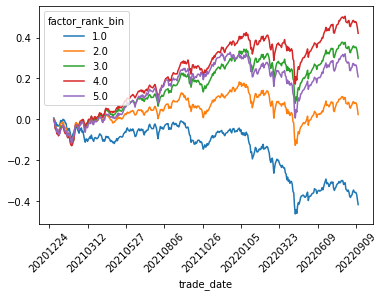

In [52]:
(alpha[alpha.trade_date > '20150101'].groupby(['factor_rank_bin', \
        'trade_date']).ret1.mean()-1).unstack().T.cumsum().plot(rot=45)

<AxesSubplot:xlabel='trade_date'>

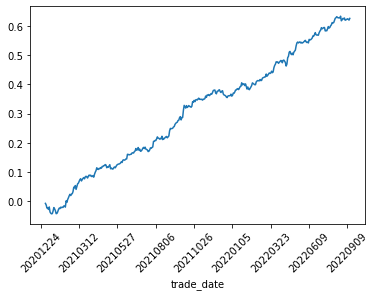

In [53]:
##计算做多做空收益
##做多factor最大的一组，做空factor最小的一组

long_ret = (alpha[(alpha.factor_rank_bin == 5)].groupby('trade_date').ret1.mean()-1).cumsum()
short_ret = (alpha[(alpha.factor_rank_bin == 1)].groupby('trade_date').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45)

In [54]:
ret_PD = (alpha.groupby(['factor_rank_bin', 'trade_date']).ret1.mean()-1.0015 ).unstack().T

if ret_PD[1.0].mean()>ret_PD[5.0].mean():
    ret_PD['diff'] = ret_PD[1.0] - ret_PD[5.0]
else:
    ret_PD['diff'] = ret_PD[5.0] - ret_PD[1.0]


In [55]:
def cal_sell_turnover(tmp):
    stock = pd.DataFrame(tmp.groupby('trade_date').apply(lambda x: set(x.ts_code))).rename(columns={0:'stock_list'})
    stock['stock_list_shift1'] = stock.stock_list.shift(1)
    stock = stock.dropna()
    freq = []
    for i in range(len(stock)):
        freq.append(1 - len(stock.iloc[i]['stock_list'] & stock.iloc[i]['stock_list_shift1'])/len(stock.iloc[i]['stock_list']))
    stock['freq'] = freq
    return stock['freq'].mean()

def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end


def max_dd_month(ret_PD):
    ret2_month = ret_PD.reset_index()
    ret2_month['month'] = [str(xx)[:6] for xx in ret2_month['trade_date']]    
    ret2_month = ret2_month.groupby('month')['ret'].sum()
    ret2_month = ret2_month.sort_values()
    return [ret2_month.head(1).values[0],ret2_month.head(1).index[0],\
            (ret2_month>0).sum()/len(ret2_month),ret2_month[ret2_month>=0].mean(),\
            ret2_month[ret2_month<0].mean()]

 

def calc_pfmc(ret_PD):
    performance = []
    for i in [1,2,3,4,5,'diff']:
        returnlist = ret_PD[i]
        ret_year = (returnlist.mean()-0)*252
        ret_sharpe = (returnlist.mean()-0)/returnlist.std()*(252**0.5)
        max_draw, start, end = max_dd(returnlist)
        winratio = (returnlist>0).sum()/len(returnlist)
        std = returnlist.std()
        performance.append([i,ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    return performance

calc_pfmc(ret_PD)

,group_name,return,sharpe,std,winratio,mdd
0,1,-0.643468,-3.197227,0.012678,0.100324,-1.016203
1,2,-0.363743,-1.778570,0.012883,0.110032,-0.602101
2,3,-0.189452,-0.903453,0.013210,0.118123,-0.393686
3,4,-0.111585,-0.518113,0.013567,0.121359,-0.333411
4,5,-0.246648,-1.082007,0.014360,0.112190,-0.466632
5,diff,0.396820,4.393649,0.005689,0.137540,-0.036380


In [56]:
ICvalue = alpha.groupby(['trade_date'])[['factor','ret1']].corr()['factor'].reset_index()
ICvalue = ICvalue[ICvalue.level_1=='ret1']
ICvalue = ICvalue[['trade_date','factor']].set_index('trade_date')

<AxesSubplot:xlabel='trade_date'>

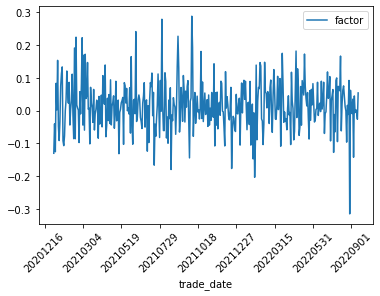

In [57]:
ICvalue.plot(rot=45)

In [58]:
display(ICvalue.mean())
display(ICvalue.mean()/ICvalue.std())

factor    0.015249
dtype: float64

factor    0.198397
dtype: float64